This kernel is dedicated for TMDB revenue prediction challenge.In this kernel i have done
- Getting started with TMDB
- Cleaning TMDB data
- Exploratory data analysis of TMDB data
- feature engineering
- Keras model
- model Evaluvation

**if you like my kernel,please do consider upvoting it**

![](https://media.giphy.com/media/WZ4M8M2VbauEo/giphy.gif)

### problem statement.

In a world... where movies made an estimated $41.7 billion in 2018, the film industry is more popular than ever. But what movies make the most money at the box office? How much does a director matter? Or the budget? For some movies, it's "You had me at 'Hello.'" For others, the trailer falls short of expectations and you think "What we have here is a failure to communicate."

In this competition, you're presented with metadata on over 7,000 past films from The Movie Database to try and predict their overall worldwide box office revenue. Data points provided include cast, crew, plot keywords, budget, posters, release dates, languages, production companies, and countries. You can collect other publicly available data to use in your model predictions, but in the spirit of this competition, use only data that would have been available before a movie's release.

### Importing required libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from collections import Counter
from sklearn import preprocessing
from datetime import datetime
import ast
from sklearn.preprocessing import normalize
from sklearn.model_selection import train_test_split
from keras import layers
from keras import models
from sklearn.preprocessing import LabelEncoder
from keras import regularizers
from keras.metrics import mean_squared_logarithmic_error
from sklearn.model_selection import KFold


Using TensorFlow backend.


###  Loading dataset

In [2]:
df_train=pd.read_csv('../input/train.csv')
df_test=pd.read_csv('../input/test.csv')

### Getting a basic ideas about the data

In [3]:
df_train.shape

(3000, 23)

In [4]:
df_test.shape

(4398, 22)

In [5]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 23 columns):
id                       3000 non-null int64
belongs_to_collection    604 non-null object
budget                   3000 non-null int64
genres                   2993 non-null object
homepage                 946 non-null object
imdb_id                  3000 non-null object
original_language        3000 non-null object
original_title           3000 non-null object
overview                 2992 non-null object
popularity               3000 non-null float64
poster_path              2999 non-null object
production_companies     2844 non-null object
production_countries     2945 non-null object
release_date             3000 non-null object
runtime                  2998 non-null float64
spoken_languages         2980 non-null object
status                   3000 non-null object
tagline                  2403 non-null object
title                    3000 non-null object
Keywords             

In [6]:
df_train.head(5)

,id,belongs_to_collection,budget,genres,homepage,imdb_id,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,release_date,runtime,spoken_languages,status,tagline,title,Keywords,cast,crew,revenue
0,1,"[{'id': 313576, 'name': 'Hot Tub Time Machine ...",14000000,"[{'id': 35, 'name': 'Comedy'}]",NaN,tt2637294,en,Hot Tub Time Machine 2,"When Lou, who has become the ""father of the In...",6.575393,/tQtWuwvMf0hCc2QR2tkolwl7c3c.jpg,"[{'name': 'Paramount Pictures', 'id': 4}, {'na...","[{'iso_3166_1': 'US', 'name': 'United States o...",2/20/15,93.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,The Laws of Space and Time are About to be Vio...,Hot Tub Time Machine 2,"[{'id': 4379, 'name': 'time travel'}, {'id': 9...","[{'cast_id': 4, 'character': 'Lou', 'credit_id...","[{'credit_id': '59ac067c92514107af02c8c8', 'de...",12314651
1,2,"[{'id': 107674, 'name': 'The Princess Diaries ...",40000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,tt0368933,en,The Princess Diaries 2: Royal Engagement,Mia Thermopolis is now a college graduate and ...,8.248895,/w9Z7A0GHEhIp7etpj0vyKOeU1Wx.jpg,"[{'name': 'Walt Disney Pictures', 'id': 2}]","[{'iso_3166_1': 'US', 'name': 'United States o...",8/6/04,113.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,It can take a lifetime to find true love; she'...,The Princess Diaries 2: Royal Engagement,"[{'id': 2505, 'name': 'coronation'}, {'id': 42...","[{'cast_id': 1, 'character': 'Mia Thermopolis'...","[{'credit_id': '52fe43fe9251416c7502563d', 'de...",95149435
2,3,NaN,3300000,"[{'id': 18, 'name': 'Drama'}]",http://sonyclassics.com/whiplash/,tt2582802,en,Whiplash,"Under the direction of a ruthless instructor, ...",64.299990,/lIv1QinFqz4dlp5U4lQ6HaiskOZ.jpg,"[{'name': 'Bold Films', 'id': 2266}, {'name': ...","[{'iso_3166_1': 'US', 'name': 'United States o...",10/10/14,105.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,The road to greatness can take you to the edge.,Whiplash,"[{'id': 1416, 'name': 'jazz'}, {'id': 1523, 'n...","[{'cast_id': 5, 'character': 'Andrew Neimann',...","[{'credit_id': '54d5356ec3a3683ba0000039', 'de...",13092000
3,4,NaN,1200000,"[{'id': 53, 'name': 'Thriller'}, {'id': 18, 'n...",http://kahaanithefilm.com/,tt1821480,hi,Kahaani,Vidya Bagchi (Vidya Balan) arrives in Kolkata ...,3.174936,/aTXRaPrWSinhcmCrcfJK17urp3F.jpg,NaN,"[{'iso_3166_1': 'IN', 'name': 'India'}]",3/9/12,122.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,NaN,Kahaani,"[{'id': 10092, 'name': 'mystery'}, {'id': 1054...","[{'cast_id': 1, 'character': 'Vidya Bagchi', '...","[{'credit_id': '52fe48779251416c9108d6eb', 'de...",16000000
4,5,NaN,0,"[{'id': 28, 'name': 'Action'}, {'id': 53, 'nam...",NaN,tt1380152,ko,마린보이,Marine Boy is the story of a former national s...,1.148070,/m22s7zvkVFDU9ir56PiiqIEWFdT.jpg,NaN,"[{'iso_3166_1': 'KR', 'name': 'South Korea'}]",2/5/09,118.0,"[{'iso_639_1': 'ko', 'name': '한국어/조선말'}]",Released,NaN,Marine Boy,NaN,"[{'cast_id': 3, 'character': 'Chun-soo', 'cred...","[{'credit_id': '52fe464b9251416c75073b43', 'de...",3923970


In [7]:
df_train.describe(include='all')

,id,belongs_to_collection,budget,genres,homepage,imdb_id,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,release_date,runtime,spoken_languages,status,tagline,title,Keywords,cast,crew,revenue
count,3000.000000,604,3.000000e+03,2993,946,3000,3000,3000,2992,3000.000000,2999,2844,2945,3000,2998.000000,2980,3000,2403,3000,2724,2987,2984,3.000000e+03
unique,NaN,422,NaN,872,941,3000,36,2975,2992,NaN,2999,2383,321,2398,NaN,401,2,2400,2969,2648,2975,2984,NaN
top,NaN,"[{'id': 645, 'name': 'James Bond Collection', ...",NaN,"[{'id': 18, 'name': 'Drama'}]",http://www.transformersmovie.com/,tt0230838,en,Joshua,Julie Kohler is prevented from suicide by her ...,NaN,/anYI1fzx90PgjO9PY3JStJZJmQT.jpg,"[{'name': 'Paramount Pictures', 'id': 4}]","[{'iso_3166_1': 'US', 'name': 'United States o...",9/10/10,NaN,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Based on a true story.,Stolen,"[{'id': 10183, 'name': 'independent film'}]",[],"[{'credit_id': '5551de509251416a93005e01', 'de...",NaN
freq,NaN,16,NaN,266,4,1,2575,2,1,NaN,1,51,1752,5,NaN,1817,2996,3,2,27,13,1,NaN
mean,1500.500000,NaN,2.253133e+07,NaN,NaN,NaN,NaN,NaN,NaN,8.463274,NaN,NaN,NaN,NaN,107.856571,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.672585e+07
std,866.169729,NaN,3.702609e+07,NaN,NaN,NaN,NaN,NaN,NaN,12.104000,NaN,NaN,NaN,NaN,22.086434,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.375323e+08
min,1.000000,NaN,0.000000e+00,NaN,NaN,NaN,NaN,NaN,NaN,0.000001,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000e+00
25%,750.750000,NaN,0.000000e+00,NaN,NaN,NaN,NaN,NaN,NaN,4.018053,NaN,NaN,NaN,NaN,94.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.379808e+06
50%,1500.500000,NaN,8.000000e+06,NaN,NaN,NaN,NaN,NaN,NaN,7.374861,NaN,NaN,NaN,NaN,104.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.680707e+07
75%,2250.250000,NaN,2.900000e+07,NaN,NaN,NaN,NaN,NaN,NaN,10.890983,NaN,NaN,NaN,NaN,118.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.891920e+07


### Missing values

In [8]:
df_train.isna().sum().sort_values(ascending=False)

belongs_to_collection    2396
homepage                 2054
tagline                   597
Keywords                  276
production_companies      156
production_countries       55
spoken_languages           20
crew                       16
cast                       13
overview                    8
genres                      7
runtime                     2
poster_path                 1
original_language           0
budget                      0
imdb_id                     0
revenue                     0
original_title              0
popularity                  0
release_date                0
status                      0
title                       0
id                          0
dtype: int64

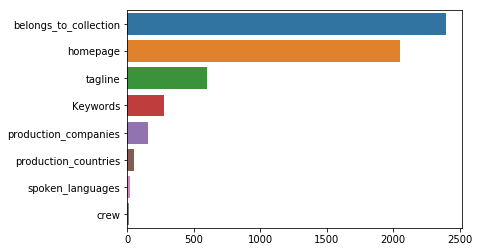

In [9]:
missing=df_train.isna().sum().sort_values(ascending=False)
sns.barplot(missing[:8],missing[:8].index)
plt.show()

There are many variable with large number of null values,we will inspect those variables first.

In [10]:
plt.style.use('seaborn')

In [11]:
import ast
dict_columns = ['belongs_to_collection', 'genres', 'production_companies',
                'production_countries', 'spoken_languages', 'Keywords', 'cast', 'crew']

def text_to_dict(df):
    for column in dict_columns:
        df[column] = df[column].apply(lambda x: {} if pd.isna(x) else ast.literal_eval(x) )
    return df
        
dfx = text_to_dict(df_train)
for col in dict_columns:
       df_train[col]=dfx[col]



#### belongs to collection




- belongs_to_collection - Contains the TMDB Id, Name, Movie Poster and Backdrop URL of a movie in JSON format. You can see the Poster and Backdrop Image like this: https://image.tmdb.org/t/p/original/. Example: https://image.tmdb.org/t/p/original//iEhb00TGPucF0b4joM1ieyY026U.jpg

In [12]:
df_train['belongs_to_collection'].apply(lambda x:len(x) if x!= {} else 0).value_counts()

0    2396
1     604
Name: belongs_to_collection, dtype: int64

Only 604 films belong to some collections

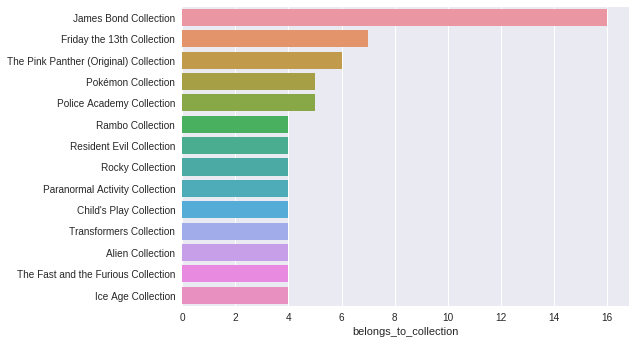

In [13]:
collections=df_train['belongs_to_collection'].apply(lambda x : x[0]['name'] if x!= {} else '?').value_counts()[1:15]
sns.barplot(collections,collections.index)
plt.show()

We can observe that james bond collection films,friday the 13th,         
The pink panther stands first among the number of films released 
in particular collection series

### Tagline

- tagline : The tagline which was assosiated with the film

In [14]:
df_train['tagline'].apply(lambda x:1 if x is not np.nan else 0).value_counts()

1    2403
0     597
Name: tagline, dtype: int64

- A wordcloud using taglines

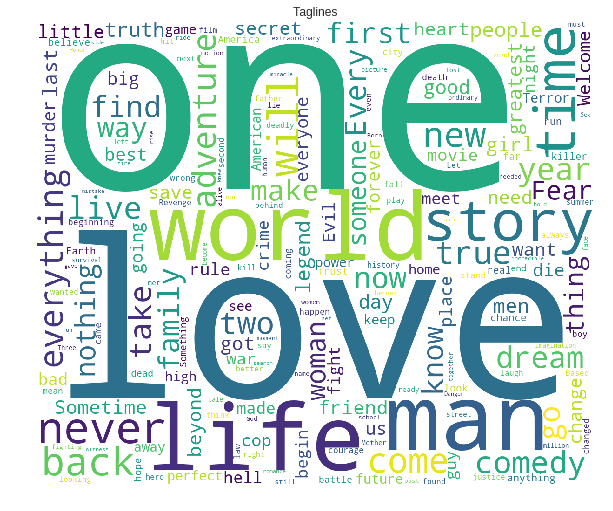

In [15]:
plt.figure(figsize=(10,10))
taglines=' '.join(df_train['tagline'].apply(lambda x:x if x is not np.nan else ''))

wordcloud = WordCloud(max_font_size=None, background_color='white', collocations=False,
                      width=1200, height=1000).generate(taglines)
plt.imshow(wordcloud)
plt.title('Taglines')
plt.axis("off")
plt.show()


#### Keywords

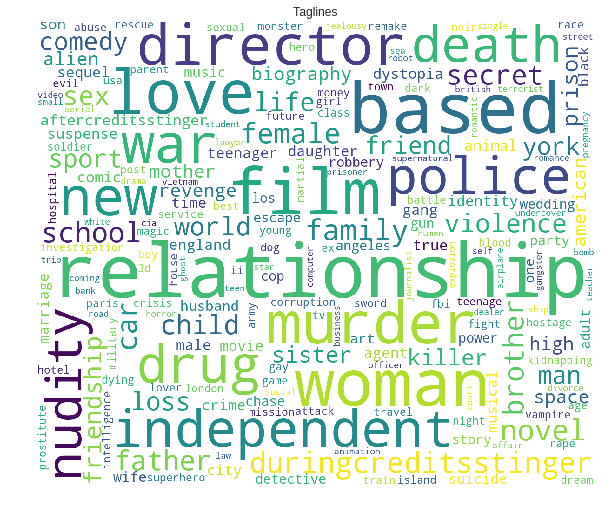

In [16]:
keywords=df_train['Keywords'].apply(lambda x: ' '.join(i['name'] for i in x) if x != {} else '')
plt.figure(figsize=(10,10))
data=' '.join(words for words in keywords)
wordcloud = WordCloud(max_font_size=None, background_color='white', collocations=False,
                      width=1200, height=1000).generate(data)
plt.imshow(wordcloud)
plt.title('Taglines')
plt.axis("off")
plt.show()


### Production companies

- The most famous production companies and the number films released by each

In [17]:
x=df_train['production_companies'].apply(lambda x : [x[i]['name'] for i in range(len(x))] if x != {} else []).values
Counter([i for j in x for i in j]).most_common(20)

[('Warner Bros.', 202),
 ('Universal Pictures', 188),
 ('Paramount Pictures', 161),
 ('Twentieth Century Fox Film Corporation', 138),
 ('Columbia Pictures', 91),
 ('Metro-Goldwyn-Mayer (MGM)', 84),
 ('New Line Cinema', 75),
 ('Touchstone Pictures', 63),
 ('Walt Disney Pictures', 62),
 ('Columbia Pictures Corporation', 61),
 ('TriStar Pictures', 53),
 ('Relativity Media', 48),
 ('Canal+', 46),
 ('United Artists', 44),
 ('Miramax Films', 40),
 ('Village Roadshow Pictures', 36),
 ('Regency Enterprises', 31),
 ('BBC Films', 30),
 ('Dune Entertainment', 30),
 ('Working Title Films', 30)]

### Production countries

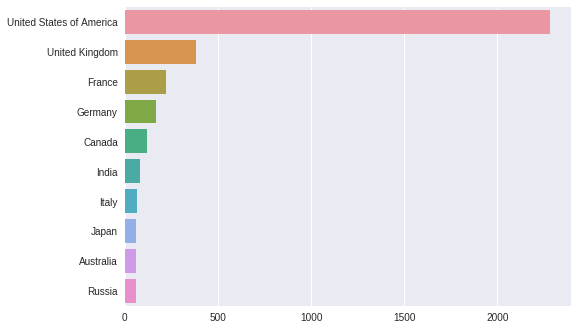

In [18]:
countries=df_train['production_countries'].apply(lambda x: [i['name'] for i in x] if x!={} else []).values
count=Counter([j for i in countries for j in i]).most_common(10)
sns.barplot([val[1] for val in count],[val[0] for val in count])

- These are the countries in which most films are released.
  USA stand first and way above 
  from other countries in terms of number of films assosiated with countries. 

### Spoken languages

- This indicates the number of languages spoken in a film

In [19]:
df_train['spoken_languages'].apply(lambda x:len(x) if x !={} else 0).value_counts()

1    2105
2     549
3     216
4      72
5      23
0      20
7       6
6       6
8       2
9       1
Name: spoken_languages, dtype: int64

- we can see that in most films there is only one language spoken in it.
- Most number of languages spoken in a film is 9.

Now we will inspect the languages spoken

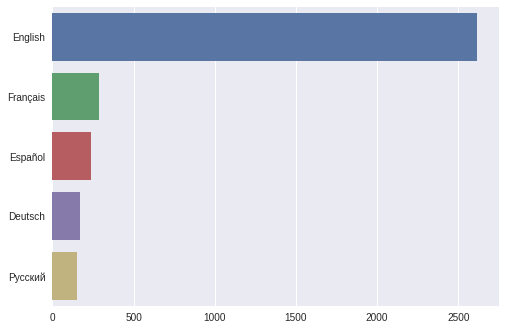

In [20]:
lang=df_train['spoken_languages'].apply(lambda x: [i['name'] for i in x] if x != {} else [])
count=Counter([i for j in lang for i in j]).most_common(5)
sns.barplot([val[1] for val in count],[val[0] for val in count])

- As expected English comes first followed by French

### Genre

- genres : Contains all the Genres Name & TMDB Id in JSON Format

We will inspect which genre films are most common

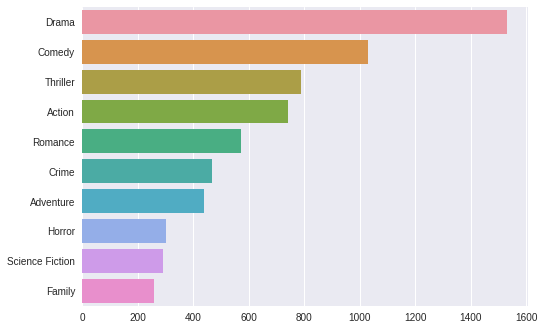

In [21]:
genre=df_train['genres'].apply(lambda x: [i['name'] for i in x] if x != {} else [])
count=Counter([i for j in genre for i in j]).most_common(10)
sns.barplot([val[1] for val in count],[val[0] for val in count])

- Drama is the most common genre followed by comedy and thrillers.

In [22]:
dfx = text_to_dict(df_test)
for col in dict_columns:
       df_test[col]=dfx[col]


### Revenue

- This is our target variable.
- We will inspect the distribution first.

/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


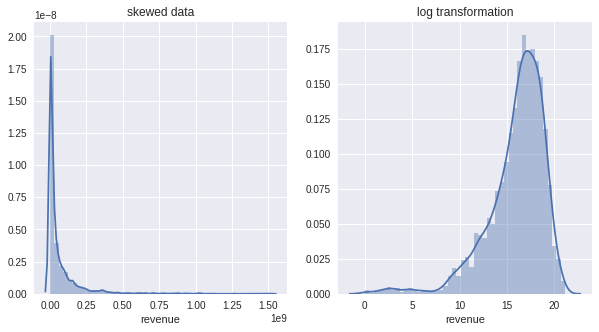

In [23]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.title('skewed data')
sns.distplot(df_train['revenue'])
plt.subplot(1,2,2)
plt.title('log transformation')
sns.distplot(np.log(df_train['revenue']))
plt.show()

- The target variable is skewed,so we will log transform it to obtain a standard distribution.

In [24]:
df_train['log_revenue']=np.log1p(df_train['revenue'])


- Histogram 

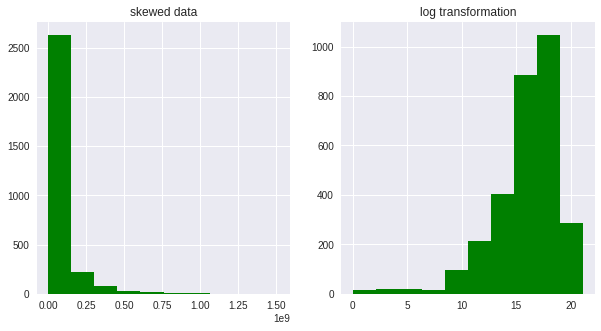

In [25]:
plt.subplots(figsize=(10,5))
plt.subplot(1,2,1)
plt.hist(df_train['revenue'],bins=10,color='g')
plt.title('skewed data')
plt.subplot(1,2,2)
plt.hist(np.log(df_train['revenue']),bins=10,color='g')
plt.title('log transformation')
plt.show()


In [26]:
df_train['revenue'].describe()

count    3.000000e+03
mean     6.672585e+07
std      1.375323e+08
min      1.000000e+00
25%      2.379808e+06
50%      1.680707e+07
75%      6.891920e+07
max      1.519558e+09
Name: revenue, dtype: float64

### Budget

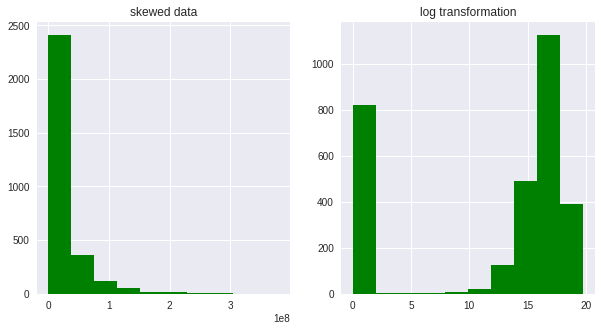

In [27]:
plt.subplots(figsize=(10,5))
plt.subplot(1,2,1)
plt.hist(df_train['budget']+1,bins=10,color='g')
plt.title('skewed data')
plt.subplot(1,2,2)
plt.hist(np.log(df_train['budget']+1),bins=10,color='g')
plt.title('log transformation')
plt.show()



#### Revenue vs budget

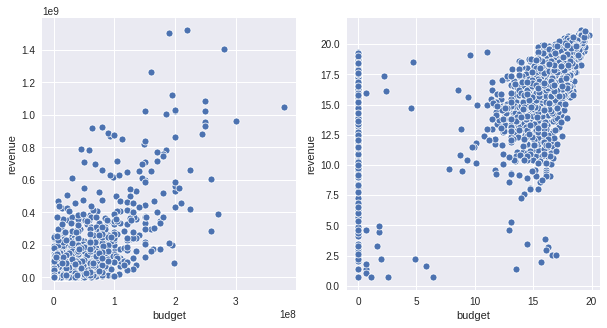

In [28]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
sns.scatterplot(df_train['budget'],df_train['revenue'])
plt.subplot(1,2,2)
sns.scatterplot(np.log1p(df_train['budget']),np.log1p(df_train['revenue']))
plt.show()

- We dont see any linear relationship among budget and revenue.

In [29]:
df_train['log_budget']=np.log1p(df_train['budget'])
df_test['log_budget']=np.log1p(df_train['budget'])

### Popularity

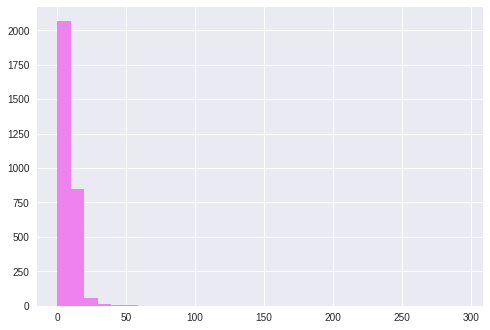

In [30]:
plt.hist(df_train['popularity'],bins=30,color='violet')
plt.show()

### Popularity vs revenue

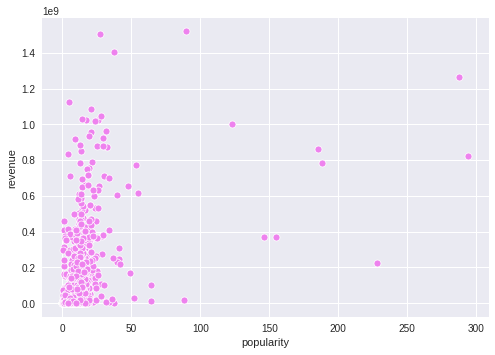

In [31]:
sns.scatterplot(df_train['popularity'],df_train['revenue'],color='violet')
plt.show()

### Extracting date features

In [32]:
def date(x):
    x=str(x)
    year=x.split('/')[2]
    if int(year)<19:
        return x[:-2]+'20'+year
    else:
        return x[:-2]+'19'+year
df_train['release_date']=df_train['release_date'].fillna('1/1/90').apply(lambda x: date(x))
df_test['release_date']=df_test['release_date'].fillna('1/1/90').apply(lambda x: date(x))


In [33]:
#from datetime import datetime
df_train['release_date']=df_train['release_date'].apply(lambda x: datetime.strptime(x,'%m/%d/%Y'))
df_test['release_date']=df_test['release_date'].apply(lambda x: datetime.strptime(x,'%m/%d/%Y'))


In [34]:
df_train['release_day']=df_train['release_date'].apply(lambda x:x.weekday())
df_train['release_month']=df_train['release_date'].apply(lambda x:x.month)
df_train['release_year']=df_train['release_date'].apply(lambda x:x.year)

In [35]:
df_test['release_day']=df_test['release_date'].apply(lambda x:x.weekday())
df_test['release_month']=df_test['release_date'].apply(lambda x:x.month)
df_test['release_year']=df_test['release_date'].apply(lambda x:x.year)

### Release day of week

Text(0, 0.5, 'No of releases')

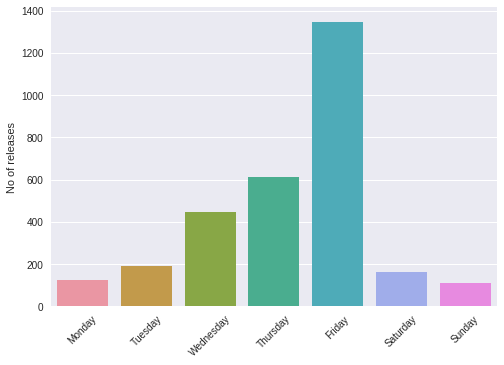

In [36]:
day=df_train['release_day'].value_counts().sort_index()
sns.barplot(day.index,day)
plt.gca().set_xticklabels(["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"],rotation='45')
plt.ylabel('No of releases')

- We can see that most films are released on friday.
- This might be because of some strategy .

#### Is there any relation between release day and revenue?

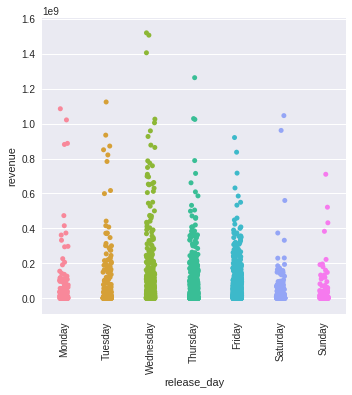

In [37]:
sns.catplot(x='release_day',y='revenue',data=df_train)
plt.gca().set_xticklabels(["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"],rotation='90')
plt.show()

#### Is there any relation between runtime and revenue?

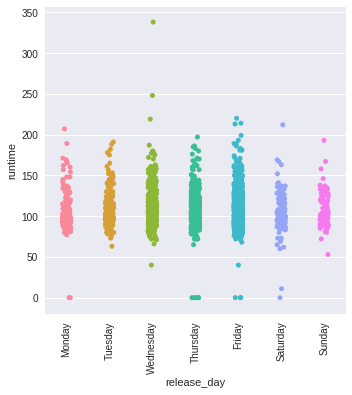

In [38]:
sns.catplot(x='release_day',y='runtime',data=df_train)
plt.gca().set_xticklabels(["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"],rotation='90')
plt.show()

#### Which months yeilds the maximum revenue?

<Figure size 720x1080 with 0 Axes>

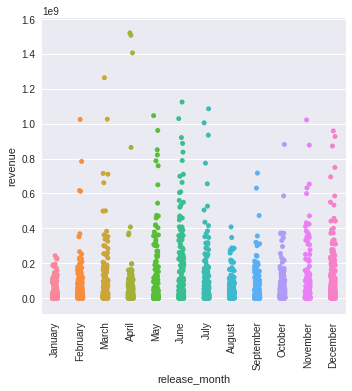

In [39]:
plt.figure(figsize=(10,15))
sns.catplot(x='release_month',y='revenue',data=df_train)
month_lst = ['January', 'February', 'March', 'April', 'May', 'June', 'July',
              'August', 'September', 'October', 'November', 'December']
plt.gca().set_xticklabels(month_lst,rotation='90')
plt.show()

- The months of April,may and june yeilds maximum revenue.

### Year vs revenue

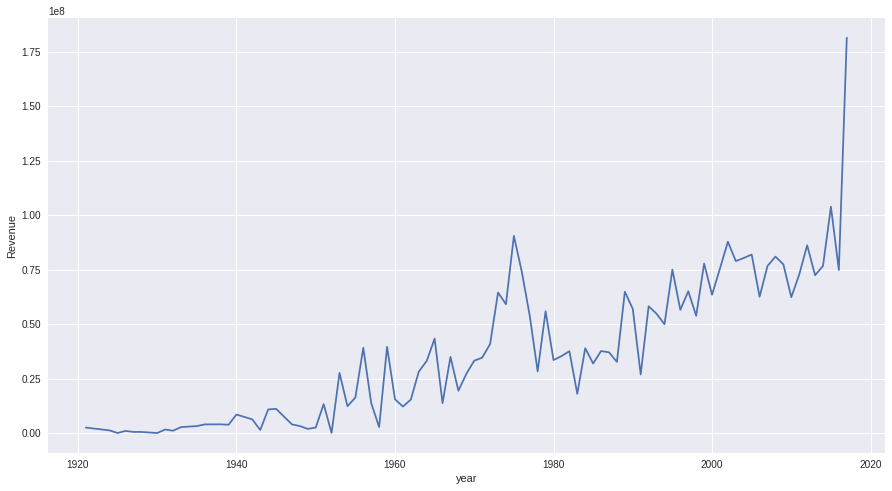

In [40]:
plt.figure(figsize=(15,8))
yearly=df_train.groupby(df_train['release_year'])['revenue'].agg('mean')
plt.plot(yearly.index,yearly)
plt.xlabel('year')
plt.ylabel("Revenue")
plt.savefig('fig')

- Revenue from films seems increasing and decreasing throughout the years.
- There is a steep increase in revenue after 2017 or so.

### Runtime

/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


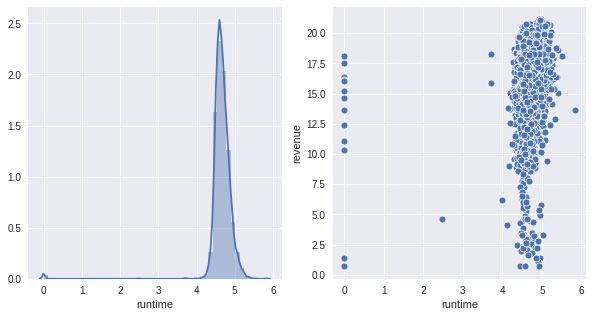

In [41]:
plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
sns.distplot(np.log1p(df_train['runtime'].fillna(0)))

plt.subplot(1,2,2)
sns.scatterplot(np.log1p(df_train['runtime'].fillna(0)),np.log1p(df_train['revenue']))


### Homepage

In [42]:
df_train['homepage'].value_counts().sort_values(ascending=False)[:5]

http://www.transformersmovie.com/                       4
http://www.lordoftherings.net/                          2
http://www.thehobbit.com/                               2
http://www.filminfocus.com/film/in_bruges               1
http://catsanddogsmovie.warnerbros.com/cmp/main.html    1
Name: homepage, dtype: int64


#### Inspecting revenue ,budget ,popularity and runtime of each genre

In [43]:
genres=df_train.loc[df_train['genres'].str.len()==1][['genres','revenue','budget','popularity','runtime']].reset_index(drop=True)
genres['genres']=genres.genres.apply(lambda x :x[0]['name'])

In [44]:
genres=genres.groupby(genres.genres).agg('mean')

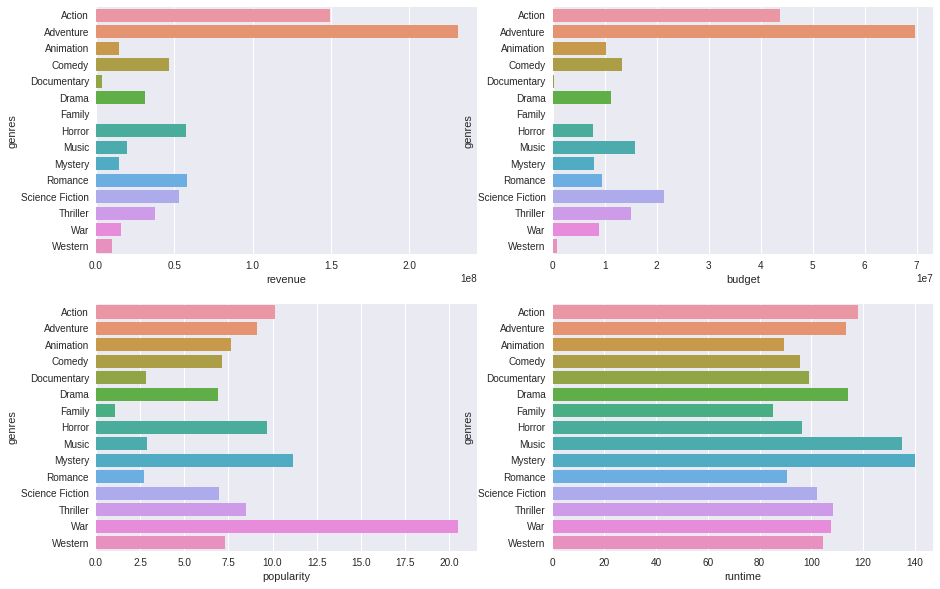

In [45]:
plt.figure(figsize=(15,10))
plt.subplot(2,2,1)
sns.barplot(genres['revenue'],genres.index)

plt.subplot(2,2,2)
sns.barplot(genres['budget'],genres.index)

plt.subplot(2,2,3)
sns.barplot(genres['popularity'],genres.index)

plt.subplot(2,2,4)
sns.barplot(genres['runtime'],genres.index)

### Crew

In [46]:

crew=df_train['crew'].apply(lambda x:[i['name'] for i in x] if x != {} else [])
Counter([i for j in crew for i in j]).most_common(15)

[('Avy Kaufman', 50),
 ('Robert Rodriguez', 44),
 ('Deborah Aquila', 40),
 ('James Newton Howard', 39),
 ('Mary Vernieu', 38),
 ('Steven Spielberg', 37),
 ('Luc Besson', 37),
 ('Jerry Goldsmith', 37),
 ('Francine Maisler', 35),
 ('Tricia Wood', 35),
 ('James Horner', 33),
 ('Kerry Barden', 32),
 ('Bob Weinstein', 30),
 ('Harvey Weinstein', 30),
 ('Janet Hirshenson', 30)]

- There are the most fomous and common crew members
- Number of films in which they appeared is also shown.

### Cast

In [47]:
cast=df_train['cast'].apply(lambda x:[i['name'] for i in x] if x != {} else [])
Counter([i for j in cast for i in j]).most_common(15)

[('Samuel L. Jackson', 30),
 ('Robert De Niro', 30),
 ('Morgan Freeman', 27),
 ('J.K. Simmons', 25),
 ('Bruce Willis', 25),
 ('Liam Neeson', 25),
 ('Susan Sarandon', 25),
 ('Bruce McGill', 24),
 ('John Turturro', 24),
 ('Forest Whitaker', 23),
 ('Willem Dafoe', 23),
 ('Bill Murray', 22),
 ('Owen Wilson', 22),
 ('Nicolas Cage', 22),
 ('Sylvester Stallone', 21)]

- There are the actors that have appeared in most films

### Feature Engineering

In reference with [kernel](https://www.kaggle.com/zero92/eda-tmdb-box-office-prediction) by B.H

In [48]:
def  prepare_data(df):
    df['_budget_runtime_ratio'] = (df['budget']/df['runtime']).replace([np.inf,-np.inf,np.nan],0)
    df['_budget_popularity_ratio'] = df['budget']/df['popularity']
    df['_budget_year_ratio'] = df['budget'].fillna(0)/(df['release_year']*df['release_year'])
    df['_releaseYear_popularity_ratio'] = df['release_year']/df['popularity']
    df['_releaseYear_popularity_ratio2'] = df['popularity']/df['release_year']
    df['budget']=np.log1p(df['budget'])
    
    df['collection_name']=df['belongs_to_collection'].apply(lambda x: x[0]['name'] if x != {} else 0)
    df['has_homepage']=0
    df.loc[(pd.isnull(df['homepage'])),'has_homepage']=1
    
    le=LabelEncoder()
    le.fit(list(df['collection_name'].fillna('')))
    df['collection_name']=le.transform(df['collection_name'].fillna('').astype(str))
    
    le=LabelEncoder()
    le.fit(list(df['original_language'].fillna('')))
    df['original_language']=le.transform(df['original_language'].fillna('').astype(str))
    
    df['_num_Keywords'] = df['Keywords'].apply(lambda x: len(x) if x != {} else 0)
    df['_num_cast'] = df['cast'].apply(lambda x: len(x) if x != {} else 0)
    
    df['isbelongto_coll']=0
    df.loc[pd.isna(df['belongs_to_collection']),'isbelongto_coll']=1
    
    df['isTaglineNA'] = 0
    df.loc[df['tagline'] == 0 ,"isTaglineNA"] = 1 

    df['isOriginalLanguageEng'] = 0 
    df.loc[ df['original_language'].astype(str) == "en" ,"isOriginalLanguageEng"] = 1
    
    df['ismovie_released']=1
    df.loc[(df['status']!='Released'),'ismovie_released']=0
    
    df['no_spoken_languages']=df['spoken_languages'].apply(lambda x: len(x))
    df['original_title_letter_count'] = df['original_title'].str.len() 
    df['original_title_word_count'] = df['original_title'].str.split().str.len() 


    df['title_word_count'] = df['title'].str.split().str.len()
    df['overview_word_count'] = df['overview'].str.split().str.len()
    df['tagline_word_count'] = df['tagline'].str.split().str.len()
    
    
    df['collection_id'] = df['belongs_to_collection'].apply(lambda x : np.nan if len(x)==0 else x[0]['id'])
    df['production_countries_count'] = df['production_countries'].apply(lambda x : len(x))
    df['production_companies_count'] = df['production_companies'].apply(lambda x : len(x))
    df['cast_count'] = df['cast'].apply(lambda x : len(x))
    df['crew_count'] = df['crew'].apply(lambda x : len(x))

    df['genders_0_crew'] = df['crew'].apply(lambda x: sum([1 for i in x if i['gender'] == 0]))
    df['genders_1_crew'] = df['crew'].apply(lambda x: sum([1 for i in x if i['gender'] == 1]))
    df['genders_2_crew'] = df['crew'].apply(lambda x: sum([1 for i in x if i['gender'] == 2]))

    for col in  ['genres', 'production_countries', 'spoken_languages', 'production_companies'] :
        df[col] = df[col].map(lambda x: sorted(list(set([n if n in train_dict[col] else col+'_etc' for n in [d['name'] for d in x]])))).map(lambda x: ','.join(map(str, x)))
        temp = df[col].str.get_dummies(sep=',')
        df = pd.concat([df, temp], axis=1, sort=False)
    df.drop(['genres_etc'], axis = 1, inplace = True)
    
    cols_to_normalize=['runtime','popularity','budget','_budget_runtime_ratio','_budget_year_ratio','_budget_popularity_ratio','_releaseYear_popularity_ratio',
    '_releaseYear_popularity_ratio2','_num_Keywords','_num_cast','no_spoken_languages','original_title_letter_count','original_title_word_count',
    'title_word_count','overview_word_count','tagline_word_count','production_countries_count','production_companies_count','cast_count','crew_count',
    'genders_0_crew','genders_1_crew','genders_2_crew']
    for col in cols_to_normalize:
        print(col)
        x_array=[]
        x_array=np.array(df[col].fillna(0))
        X_norm=normalize([x_array])[0]
        df[col]=X_norm
    
    df = df.drop(['belongs_to_collection','genres','homepage','imdb_id','overview','id'
    ,'poster_path','production_companies','production_countries','release_date','spoken_languages'
    ,'status','title','Keywords','cast','crew','original_language','original_title','tagline', 'collection_id'
    ],axis=1)
    
    df.fillna(value=0.0, inplace = True) 

    return df

    

In [49]:
def get_json(df):
    global dict_columns
    result=dict()
    for col in dict_columns:
        d=dict()
        rows=df[col].values
        for row in rows:
            if row is None: continue
            for i in row:
                if i['name'] not in d:
                    d[i['name']]=0
                else:
                    d[i['name']]+=1
            result[col]=d
    return result
    
    

    
train_dict=get_json(df_train)
test_dict=get_json(df_test)


In [50]:
df_train.shape

(3000, 28)

In [51]:
for col in dict_columns :
    
    remove = []
    train_id = set(list(train_dict[col].keys()))
    test_id = set(list(test_dict[col].keys()))   
    
    remove += list(train_id - test_id) + list(test_id - train_id)
    for i in train_id.union(test_id) - set(remove) :
        if train_dict[col][i] < 10 or i == '' :
            remove += [i]
    for i in remove :
        if i in train_dict[col] :
            del train_dict[col][i]
        if i in test_dict[col] :
            del test_dict[col][i]
                  
    

            

### Splitting train and test

In [52]:
df_test['revenue']=np.nan
all_data=prepare_data((pd.concat([df_train,df_test]))).reset_index(drop=True)
train=all_data.loc[:df_train.shape[0]-1,:]
test=all_data.loc[df_train.shape[0]:,:]
print(train.shape)


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  


runtime
popularity
budget
_budget_runtime_ratio
_budget_year_ratio
_budget_popularity_ratio
_releaseYear_popularity_ratio
_releaseYear_popularity_ratio2
_num_Keywords
_num_cast
no_spoken_languages
original_title_letter_count
original_title_word_count
title_word_count
overview_word_count
tagline_word_count
production_countries_count
production_companies_count
cast_count
crew_count
genders_0_crew
genders_1_crew
genders_2_crew
(3000, 173)


In [53]:
all_data.head()

,budget,log_budget,log_revenue,popularity,release_day,release_month,release_year,revenue,runtime,_budget_runtime_ratio,_budget_popularity_ratio,_budget_year_ratio,_releaseYear_popularity_ratio,_releaseYear_popularity_ratio2,collection_name,has_homepage,_num_Keywords,_num_cast,isbelongto_coll,isTaglineNA,isOriginalLanguageEng,ismovie_released,no_spoken_languages,original_title_letter_count,original_title_word_count,title_word_count,overview_word_count,tagline_word_count,production_countries_count,production_companies_count,cast_count,crew_count,genders_0_crew,genders_1_crew,genders_2_crew,Action,Adventure,Animation,Comedy,Crime,...,Legendary Pictures,Lions Gate Films,Lionsgate,Metro-Goldwyn-Mayer (MGM),Millennium Films,Miramax Films,Morgan Creek Productions,New Line Cinema,New Regency Pictures,Original Film,Orion Pictures,Paramount Pictures,Participant Media,PolyGram Filmed Entertainment,Regency Enterprises,Relativity Media,Revolution Studios,Scott Free Productions,Scott Rudin Productions,Screen Gems,Silver Pictures,Spyglass Entertainment,Studio Babelsberg,StudioCanal,Summit Entertainment,TF1 Films Production,TSG Entertainment,The Weinstein Company,Touchstone Pictures,TriStar Pictures,Twentieth Century Fox Film Corporation,UK Film Council,United Artists,Universal Pictures,Village Roadshow Pictures,Walt Disney Pictures,Warner Bros.,Wild Bunch,Working Title Films,production_companies_etc
0,0.013684,16.454568,16.326300,0.005148,4,2,2015,12314651.0,0.009848,0.004637,0.000108,0.003731,1.088886e-07,0.005133,282,1,0.004860,0.010233,0,0,0,1,0.006838,0.015051,0.018665,0.018296,0.005643,0.014926,0.007503,0.009940,0.010233,0.022525,0.026486,0.000000,0.014311,0,0,0,1,0,...,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
1,0.014557,17.504390,18.370959,0.006459,4,8,2004,95149435.0,0.011966,0.010905,0.000245,0.010778,8.632387e-08,0.006475,641,1,0.004860,0.008528,0,0,0,1,0.006838,0.027366,0.022398,0.021955,0.013426,0.017640,0.007503,0.003313,0.008528,0.002816,0.000449,0.013881,0.004403,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
2,0.012482,15.009433,16.387512,0.050345,4,10,2014,13092000.0,0.011119,0.000968,0.000003,0.000880,1.112955e-08,0.050224,1,0,0.014579,0.021746,0,0,0,1,0.006838,0.005473,0.003733,0.003659,0.004086,0.013569,0.007503,0.009940,0.021746,0.020023,0.021997,0.013881,0.012109,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
3,0.011641,13.997833,16.588099,0.002486,4,3,2012,16000000.0,0.012919,0.000303,0.000019,0.000321,2.251759e-07,0.002482,1,0,0.008504,0.002985,0,0,0,1,0.013676,0.004789,0.003733,0.003659,0.020626,0.000000,0.007503,0.000000,0.002985,0.000939,0.001347,0.000000,0.000000,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0.000000,0.000000,15.182615,0.000899,3,2,2009,3923970.0,0.012495,0.000000,0.000000,0.000000,6.217854e-07,0.000899,1,1,0.000000,0.001706,0,0,0,1,0.006838,0.002737,0.003733,0.007318,0.006227,0.000000,0.007503,0.000000,0.001706,0.000626,0.000898,0.000000,0.000000,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [54]:
train.drop('revenue',axis=1,inplace=True)

/opt/conda/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [55]:
y=train['log_revenue']
X=train.drop(['log_revenue'],axis=1)

In [56]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.1)
kfold=KFold(n_splits=3,random_state=42,shuffle=True)


In [57]:
X.columns

Index(['budget', 'log_budget', 'popularity', 'release_day', 'release_month',
       'release_year', 'runtime', '_budget_runtime_ratio',
       '_budget_popularity_ratio', '_budget_year_ratio',
       ...
       'Twentieth Century Fox Film Corporation', 'UK Film Council',
       'United Artists', 'Universal Pictures', 'Village Roadshow Pictures',
       'Walt Disney Pictures', 'Warner Bros.', 'Wild Bunch',
       'Working Title Films', 'production_companies_etc'],
      dtype='object', length=171)

### Keras model

In [58]:
from keras import optimizers

    
model=models.Sequential()
model.add(layers.Dense(356,activation='relu',kernel_regularizer=regularizers.l1(.001),input_shape=(X.shape[1],)))
#model.add(layers.Dropout(0.1))
model.add(layers.Dense(256,kernel_regularizer=regularizers.l1(.001),activation='relu'))
model.add(layers.Dense(1))
model.compile(optimizer=optimizers.rmsprop(lr=.001),loss='mse'
,metrics=['mean_squared_logarithmic_error'])


Instructions for updating:
Colocations handled automatically by placer.


In [59]:

epochs=40

In [60]:
hist=model.fit(X_train,y_train,epochs=epochs,verbose=0,validation_data=(X_test,y_test))

Instructions for updating:
Use tf.cast instead.


### Mean absolute error

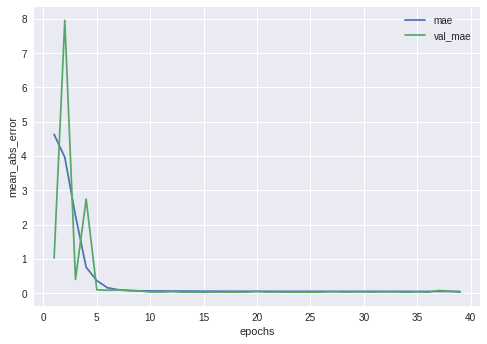

In [61]:

mae=hist.history['mean_squared_logarithmic_error']
plt.plot(range(1,epochs),mae[1:],label='mae')
plt.xlabel('epochs')
plt.ylabel('mean_abs_error')
mae=hist.history['val_mean_squared_logarithmic_error']
plt.plot(range(1,epochs),mae[1:],label='val_mae')
plt.legend()


### Loss

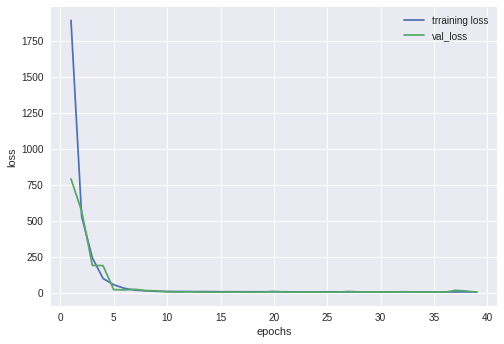

In [62]:
mae=hist.history['loss']
plt.plot(range(1,epochs),mae[1:],label='trraining loss')
plt.xlabel('epochs')
plt.ylabel('loss')
mae=hist.history['val_loss']
plt.plot(range(1,epochs),mae[1:],label='val_loss')
plt.legend()


### Making my submission

In [63]:
test.drop(['revenue','log_revenue'],axis=1,inplace=True)

/opt/conda/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [64]:
y=np.expm1(model.predict(test))
df_test['revenue']=y
df_test[['id','revenue']].to_csv('submission.csv',index=False)



**If you like my kernel please consider upvoting,Thank you !**